In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss, top_k_accuracy_score, roc_auc_score, average_precision_score

### Load data and obtain train-test split

In [2]:
train_data = pd.read_csv('../data/fashion-mnist_train.csv')
test_data = pd.read_csv('../data/fashion-mnist_test.csv')

X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

print(f"Data with {len(X_train.columns)} features")
print(f"Train set of size {len(X_train)} with {len(y_train)} labels")
print(f"Test set of size {len(X_test)} with {len(y_test)} labels")

Data with 784 features
Train set of size 60000 with 60000 labels
Test set of size 10000 with 10000 labels


In [6]:
# Define class mappings
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [16]:
# Resize flattened images to 28x28 for Train and Test sets
X_train_images = [row.values.reshape(28, 28).astype('uint8') for _, row in X_train.iterrows()]
X_test_images = [row.values.reshape(28, 28).astype('uint8') for _, row in X_test.iterrows()]

### Visualise raw data

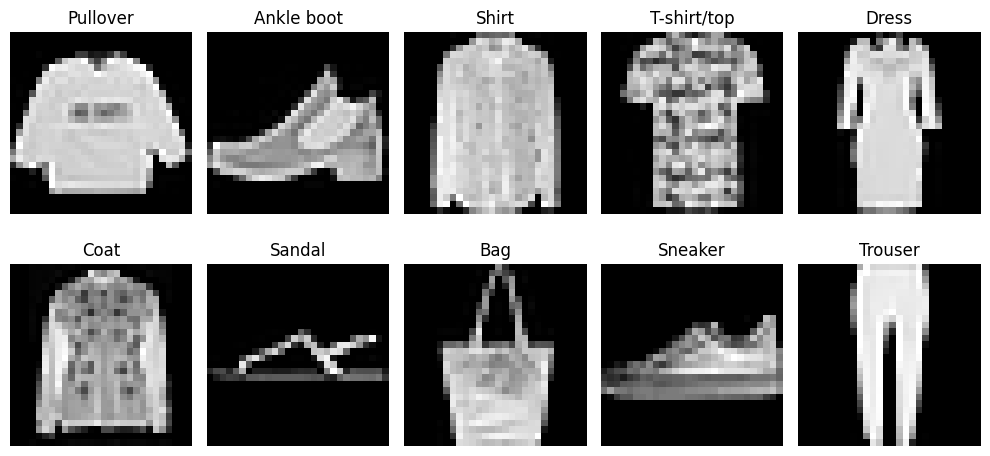

In [48]:
fig, ax = plt.subplots(2,5,figsize=(10,5))
shown = []
row, col = 0, 0

for idx, _img in enumerate(X_train_images):
    if y_train[idx] not in shown:
        ax[row][col].imshow(_img, cmap='gray')
        ax[row][col].set_title(f"{class_names[y_train[idx]]}")
        ax[row][col].set_axis_off()
        shown.append(y_train[idx])
        col += 1
        row += int(col/5)
        col = col%5

fig.tight_layout()
plt.show()

### Data Preprocessing: Feature Extraction with SIFT

In [51]:
resize_factor = (100,100)

def sift(images, resize):
    
    sift_detector = cv2.SIFT_create()
    keypoints = []
    features = []

    for _img in images:
        
        # Resize as SIFT works better on larger images
        resized = cv2.resize(_img, resize, interpolation=cv2.INTER_CUBIC)
        
        kp, des = sift_detector.detectAndCompute(resized, None)
        
        # Handles missing keypoints
        if des is None:
            des = np.zeros((1, 128))
        pooled = np.mean(des, axis=0)
        
        keypoints.append(kp)
        features.append(pooled)

    return keypoints, np.array(features)

In [54]:
sift_train_keypoints, sift_train_features = sift(X_train_images, resize_factor)
sift_test_keypoints, sift_test_features = sift(X_test_images, resize_factor)

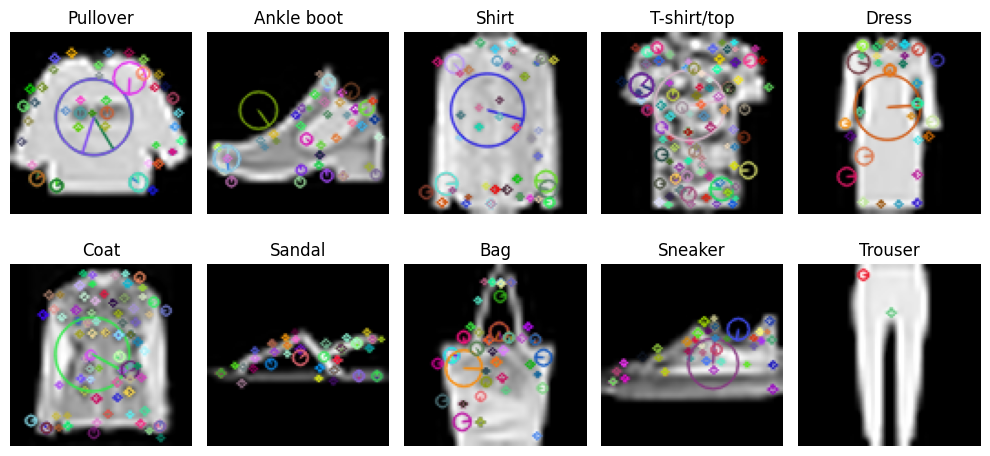

In [56]:
# Visualise keypoints
fig, ax = plt.subplots(2,5,figsize=(10,5))
shown = []
row, col = 0, 0

for idx, _img in enumerate(X_train_images):
    
    if y_train[idx] not in shown:
        resized = cv2.resize(_img, resize_factor, interpolation=cv2.INTER_CUBIC)
        _kp = sift_train_keypoints[idx]
        img_kp = cv2.drawKeypoints(resized, _kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        ax[row][col].imshow(img_kp, cmap='gray')
        ax[row][col].set_title(f"{class_names[y_train[idx]]}")
        ax[row][col].set_axis_off()
        shown.append(y_train[idx])
        col += 1
        row += int(col/5)
        col = col%5

fig.tight_layout()
plt.show()

In [58]:
print("Train Random Forest with preprocessed SIFT data")
print(f"{len(sift_train_features)} training data with {len(sift_train_features[0])} features each")
print(f"{len(y_train)} training labels")

# Using ideal hyperparameters
forest_sift = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42
)
forest_sift.fit(sift_train_features, y_train)

Train Random Forest with preprocessed SIFT data
60000 training data with 128 features each
60000 training labels


RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)

In [59]:
sift_train_predictions = forest_sift.predict(sift_train_features)
sift_test_predictions = forest_sift.predict(sift_test_features)

sift_train_acc = accuracy_score(y_train, sift_train_predictions)
sift_test_acc = accuracy_score(y_test, sift_test_predictions)
print("Training Accuracy:", sift_train_acc)
print("Test Accuracy:", sift_test_acc)

Training Accuracy: 0.9998333333333334
Test Accuracy: 0.6344


In [63]:
print(classification_report(y_test, sift_test_predictions))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1000
           1       0.84      0.90      0.87      1000
           2       0.64      0.58      0.61      1000
           3       0.53      0.41      0.47      1000
           4       0.50      0.59      0.54      1000
           5       0.68      0.82      0.74      1000
           6       0.48      0.38      0.42      1000
           7       0.65      0.73      0.69      1000
           8       0.74      0.58      0.65      1000
           9       0.68      0.77      0.72      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



### Data Preprocessing: Image Augmentations

In [65]:
# Generate one augmented image per original image
X_train_images_augmented = []
y_train_augmented = []

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30)
])

for i, _image in enumerate(X_train_images):
    
    # One augmented image for each existing image
    _image_pil = Image.fromarray(_image.astype('uint8'))
    _image_augmented_pil = transform(_image_pil)
    _image_augmented = np.array(_image_augmented_pil)

    X_train_images_augmented.append(_image)
    X_train_images_augmented.append(_image_augmented)

    y_train_augmented.append(y_train[i])
    y_train_augmented.append(y_train[i])

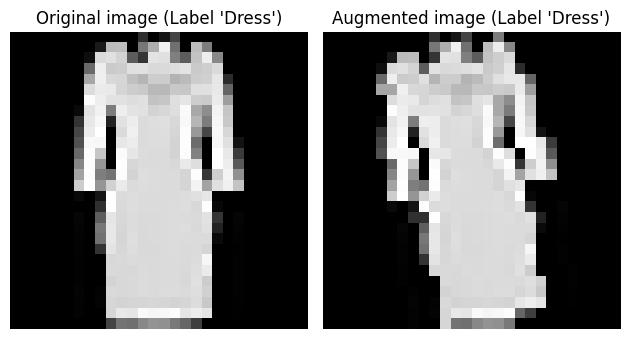

In [67]:
# To visualise sample augmented image
sample_image = X_train_images_augmented[8]
sample_image_augmented = X_train_images_augmented[9]

fig,ax = plt.subplots(1,2)
ax[0].imshow(sample_image, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f"Original image ({class_names[y_train_augmented[8]]})")
ax[1].imshow(sample_image_augmented, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f"Augmented image ({class_names[y_train_augmented[9]]})")
fig.tight_layout()
plt.show()

In [68]:
# Flatten images
X_train_augmented = [i.flatten() for i in X_train_images_augmented]

print("Train Random Forest with additional augmented data")
print(f"{len(X_train_augmented)} training data with {len(X_train_augmented[0])} features each")
print(f"{len(y_train_augmented)} training labels")

# Using ideal hyperparameters
forest_augmented = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42
)
forest_augmented.fit(X_train_augmented, y_train_augmented)

Train Random Forest with additional augmented data
120000 training data with 784 features each
120000 training labels


RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)

In [69]:
augmented_train_predictions = forest_augmented.predict(X_train_augmented)
augmented_test_predictions = forest_augmented.predict(X_test)

augmented_train_acc = accuracy_score(y_train_augmented, augmented_train_predictions)
augmented_test_acc = accuracy_score(y_test, augmented_test_predictions)
print("Training Accuracy:", augmented_train_acc)
print("Test Accuracy:", augmented_test_acc)

C:\Users\limZH\OneDrive\NUS\Y3\Y3S2\CS3244\Project\venv_pc\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Training Accuracy: 0.9996666666666667
Test Accuracy: 0.8804


In [70]:
print(classification_report(y_test, augmented_test_predictions))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.89      0.93      0.91      1000
           4       0.79      0.86      0.82      1000
           5       0.97      0.94      0.96      1000
           6       0.74      0.60      0.66      1000
           7       0.92      0.93      0.92      1000
           8       0.95      0.97      0.96      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Train Random Forest

In [72]:
print("Train Random Forest on raw data")
print(f"{len(X_train)} training data with {len(X_train.columns)} features each")
print(f"{len(y_train)} training labels")

# Using ideal hyperparameters
forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42
)
forest.fit(X_train, y_train)

Train Random Forest on raw data
60000 training data with 784 features each
60000 training labels


RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)

In [81]:
train_predictions = forest.predict(X_train)
test_predictions = forest.predict(X_test)

train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Training Accuracy: 0.9999666666666667
Test Accuracy: 0.8874


### Evaluate Random Forest

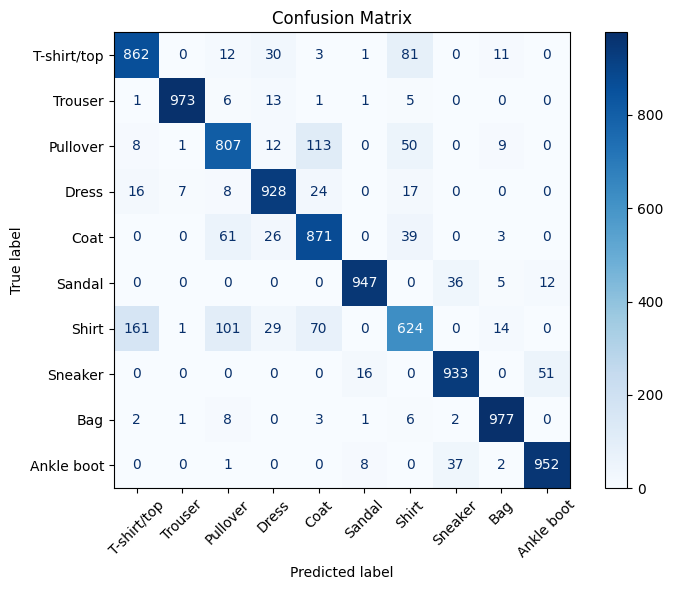

In [82]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names.values())
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.89      0.93      0.91      1000
           4       0.80      0.87      0.84      1000
           5       0.97      0.95      0.96      1000
           6       0.76      0.62      0.68      1000
           7       0.93      0.93      0.93      1000
           8       0.96      0.98      0.97      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [102]:
# Log Loss
y_prob = forest.predict_proba(X_test)
logloss = log_loss(y_test, y_prob)
print(f"Log loss: {logloss:.4f}")

# Class Accuracy

# Top-k Accuracy
top3_acc = top_k_accuracy_score(y_test, y_prob, k=3)
print(f"Top-3 Accuracy: {top3_acc:.4f}")

# AUC-ROC, AUC-PR
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
pr_auc = average_precision_score(y_test_bin, y_prob, average='macro')
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

Log loss: 0.3602
Top-3 Accuracy: 0.9906
AUC-ROC: 0.9918
PR-AUC: 0.9434


### Training Decision Tree

In [85]:
print("Train Decision Tree without augmented images added")
print(f"Training set size of {len(X_train)} with {len(X_train.columns)} features")
print(f"{len(y_train)} labels")

# Train without augmented images
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_train_predictions = tree.predict(X_train)
tree_test_predictions = tree.predict(X_test)

tree_train_acc = accuracy_score(y_train, tree_train_predictions)
tree_test_acc = accuracy_score(y_test, tree_test_predictions)
print("Training Accuracy:", tree_train_acc)
print("Test Accuracy:", tree_test_acc)

Train Decision Tree without augmented images added
Training set size of 60000 with 784 features
60000 labels
Training Accuracy: 1.0
Test Accuracy: 0.7996


### Tune hyperparameters for Random Forest

In [31]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [300],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 0.3],
    'bootstrap': [True],
}

n_combi = 1
for i in param_grid:
    n_combi *= len(param_grid[i])
print(f"{n_combi} hyperparameter combinations")

54 hyperparameter combinations


In [ ]:
# Grid search to find the best combination of hyperparameter
# `cv`parameter is for cross validation, which ensures reliable evaluation of each hyperparameter combination
# TAKES VERY LONG TO RUN !!! Hyperparameter tuning was done with data size 10000 which took 1.5 hours
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
best_forest = grid_search.best_estimator_
best_forest.fit(X_train, y_train)
train_predictions = forest.predict(X_train)
test_predictions = forest.predict(X_test)

train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print(best_forest)
print(f"Min samples split {best_forest.min_samples_split}")
print(f"Min samples leaf {best_forest.min_samples_leaf}")
print(f"Max features {best_forest.max_features}")
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)